In [540]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import time
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FunctionTransformer, make_pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer

# EXAMEN

## EJERCICIO 1

Carga el conjunto de datos Iris (el de las flores según la anchura y la altura del pétalo y del sépalo) desde scikit-learn (se ha hecho en algún ejercicio).

Explora los datos visualmente utilizando gráficos: representa la distribución de cada variable (todas las de X e y), diagramas de cajas de cada variable (todas las de X) y la matriz de correlaciones para entender las relaciones entre las características. ¿Qué puedes deducir?

Divide el conjunto de datos en entrenamiento y prueba, estratificando por el tipo de flor.

Prepara los datos mediante una pipeline.

Entrena y evalúa un clasificador Random Forest utilizando validación cruzada. ¿Qué métrica has usado para evaluar el modelo y por qué? ¿Cuál es el mejor y el peor error que consigues?

Optimiza el número de árboles, ¿cuál es el mejor valor?

Evalúa el rendimiento del modelo optimizado en el conjunto de prueba.

Guarda el modelo en un fichero y cárgalo desde un fichero .py que pida 4 datos para una nueva flor (anchura del pétalo, longitud del pétalo, anchura del sépalo y longitud del sépalo) y prediga de que clase es la flor (quiero que me de un nombre, no un número y hay que controlar las excepciones).

Examen de Irune Guinea 🚀

## Obtención de datos
Primero cargo los datos al dataframe

In [541]:
iris = load_iris(as_frame=True)


In [542]:
X = iris.data
y = iris.target

Los tipos de flores

In [543]:
list(iris.target_names)

[np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]

## Exploración de datos

In [544]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [545]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [546]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [547]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 150 entries, 0 to 149
Series name: target
Non-Null Count  Dtype
--------------  -----
150 non-null    int64
dtypes: int64(1)
memory usage: 1.3 KB


In [548]:
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [549]:
y.describe()

count    150.000000
mean       1.000000
std        0.819232
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: target, dtype: float64

In [550]:
y.unique()

array([0, 1, 2])

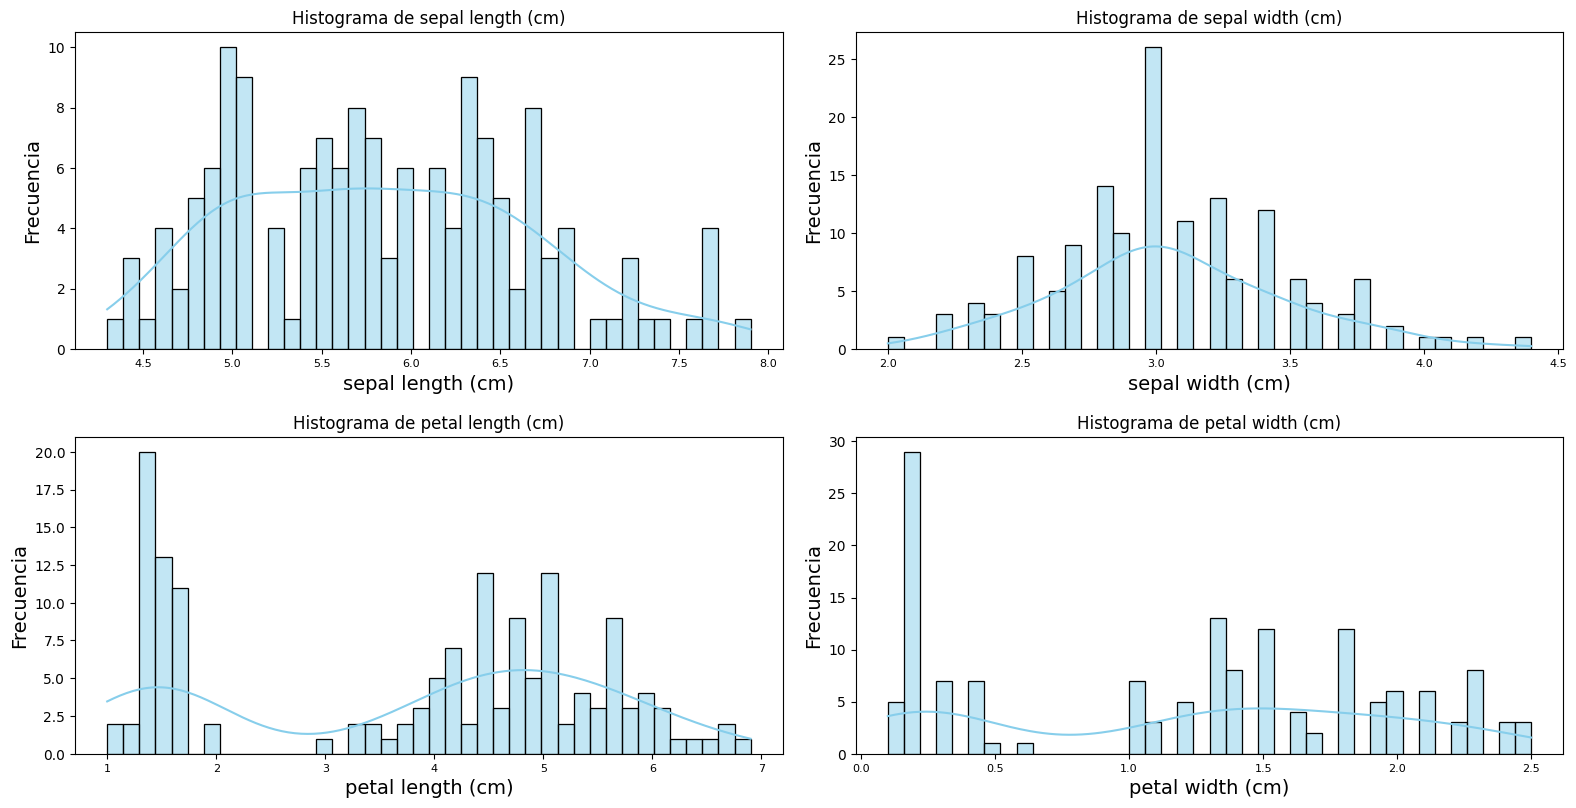

In [551]:
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

for idx, columna in enumerate(X.columns):
    sns.histplot(data=X, x=columna, bins=40, kde=True, ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'Histograma de {columna}', fontsize=12)
    axes[idx].set_xlabel(columna)
    axes[idx].set_ylabel('Frecuencia')

for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

# Para que no se me junten
plt.tight_layout()
plt.show()

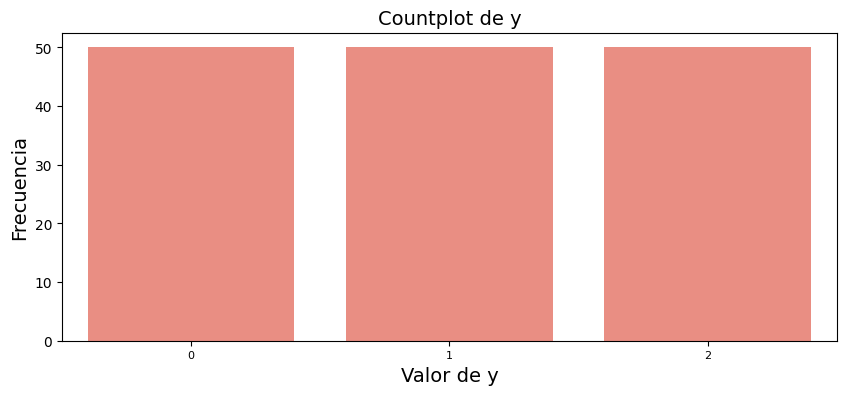

In [552]:
plt.figure(figsize=(10, 4))
sns.countplot(x=y, color="salmon")

plt.title('Countplot de y')
plt.xlabel('Valor de y')
plt.ylabel('Frecuencia')

plt.show()


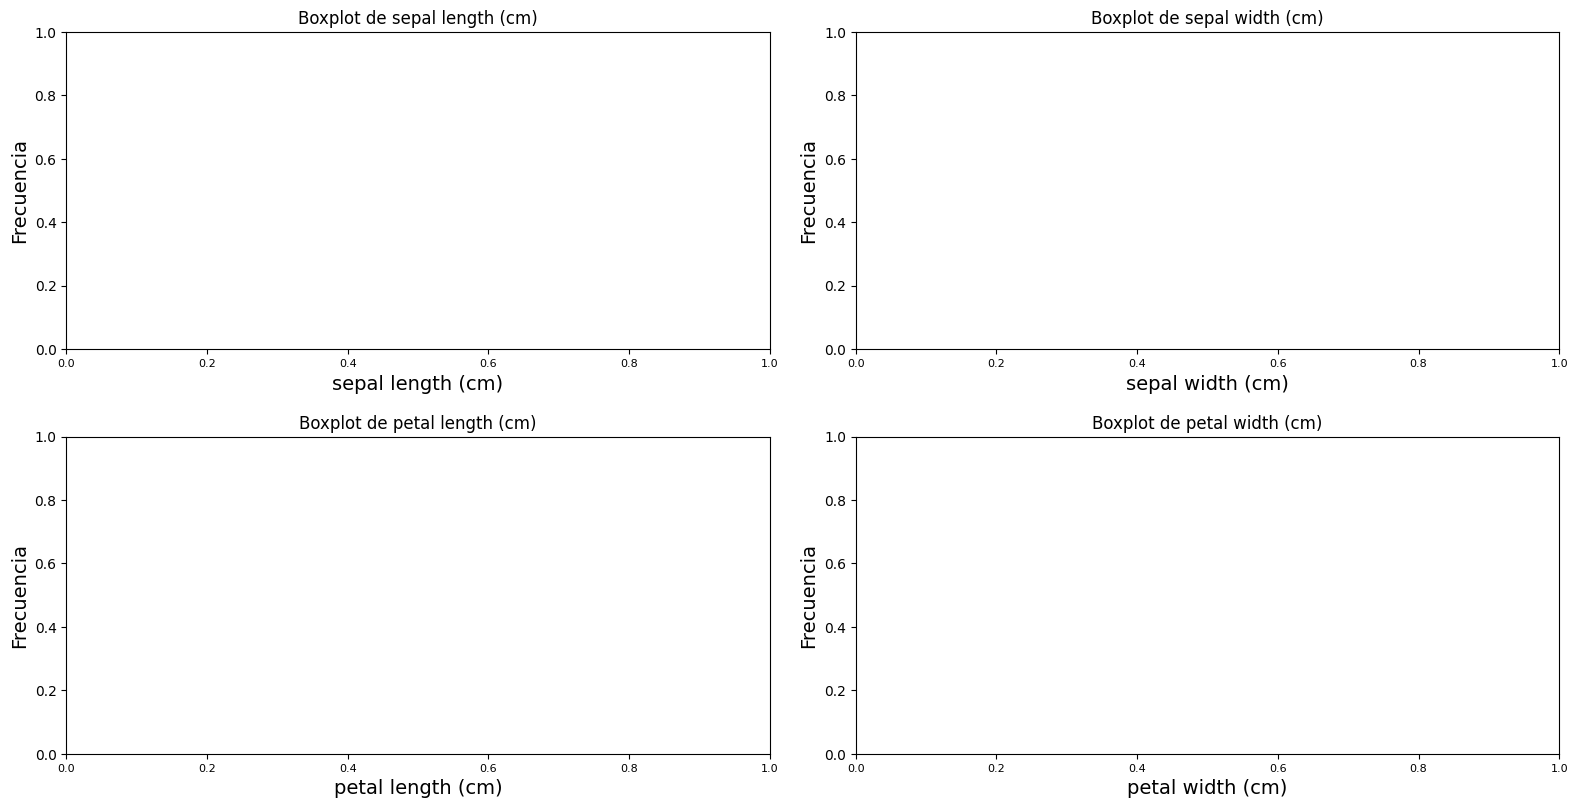

In [553]:
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

for idx, columna in enumerate(X.columns):
    sns.boxplot(data=X,x=columna ,y=idx)
    axes[idx].set_title(f'Boxplot de {columna}', fontsize=12)
    axes[idx].set_xlabel(columna)
    axes[idx].set_ylabel('Frecuencia')

for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

# Para que no se me junten
plt.tight_layout()
plt.show()

In [475]:
# Combinar X e y en un solo DataFrame
data = X.copy()
data['target'] = y

# Calcular la matriz de correlación
correlaciones = data.corr(numeric_only=True)

# Establecer la columna objetivo
correlaciones["target"].sort_values(ascending=False)


target               1.000000
petal width (cm)     0.956547
petal length (cm)    0.949035
sepal length (cm)    0.782561
sepal width (cm)    -0.426658
Name: target, dtype: float64

In [476]:
correlaciones.style.background_gradient()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
sepal length (cm),1.000000,-0.117570,0.871754,0.817941,0.782561
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126,-0.426658
petal length (cm),0.871754,-0.428440,1.000000,0.962865,0.949035
petal width (cm),0.817941,-0.366126,0.962865,1.000000,0.956547
target,0.782561,-0.426658,0.949035,0.956547,1.000000


### ¿Qué podemos deducir?
Las variables más correlacionadas con la variable objetivo son petal width, petal length y sepal length.
Todas son bastante altas, quedandose un poco más atras sepal width.

## Dividir los datos
Como no especifica hago un 20% para pruebas

In [477]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Preparación de datos

Solo hay que estandarizar las columnas y por lo tanto se puede hacer directamente en la pipeline que define el modelo en el siguiente punto, pero como pide explicitamente hacer una pipeline la hago.

In [478]:
pipeline_estandarizar = make_pipeline(
    SimpleImputer(strategy='mean'), 
    StandardScaler() 
)

### Entrenar y evaluar

In [479]:
pipeline_iris = make_pipeline(StandardScaler(),RandomForestClassifier(n_estimators=100))
pipeline_iris.fit(X_train, y_train)

random_forest_cruzada = cross_val_score(pipeline_iris, X_train, y_train, cv=5, scoring='accuracy')

# Mostrar los resultados de la validación cruzada
print(f"Puntuaciones de validación cruzada: {random_forest_cruzada}")
print(f"Puntuación media de validación cruzada: {np.mean(random_forest_cruzada)}")

Puntuaciones de validación cruzada: [0.91666667 0.95833333 0.95833333 0.95833333 0.95833333]
Puntuación media de validación cruzada: 0.95


He usado accuracy porque da mejor resultado en problemas balanceados.
El mejor resultado que consigo es 0.95833333 y el peor 0.91666667

### Optimización 

In [480]:
from scipy.stats import randint

# Crear un pipeline con make_pipeline
pipeline = make_pipeline(pipeline_iris,RandomForestClassifier())

param_grid  = {
    'randomforestclassifier__n_estimators': np.arange(10, 200), 

}

grid_search = GridSearchCV(pipeline_iris, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)

mejor_modelo = grid_search.best_estimator_



Mejores hiperparámetros: {'randomforestclassifier__n_estimators': np.int64(85)}


El mejor numero de arboles es 18

## Evaluación en conjunto de prueba

In [481]:
prediccion = mejor_modelo.predict(X_test)
precision = accuracy_score(y_test, prediccion)
print(f"Precisión: {precision}")


Precisión: 0.9666666666666667


In [482]:
joblib.dump(modelo, "./modelo_flores.pkl")

['./modelo_flores.pkl']

## EJERCICIO 2

En este ejercicio, trabajarás con un conjunto de datos de pruebas creados (ejercicio2.csv). 

Tu objetivo es construir un modelo de regresión que pueda predecir con precisión la variable dependiente y a partir de las variables independientes x1 y x2. 

Deberás:
* Cargar los datos
* Visualizar gráficamente los datos (x1 respecto a y e x2 respecto a y)
* Dividir los datos en conjunto de entrenamiento y pruebas
* Probar diferentes modelos de regresión polinómica (PolynomialFeatures + ), hasta ver cuál es el mejor degree (y explicarlo gráficamente y por medida del error en los conjuntos de entrenamiento y pruebas), no hace falta que uses validación cruzada. ¿Qué medición has usado para evaluar el modelo y por qué? ¿cuál es el mejor degree?
* Probar ahora con Elastic Net, optimizando los hiperparámetros con búsqueda exhaustiva, ¿ha mejorado con esta regularización? ¿cuáles son los mejores datos para los hiperparámetros?

Pista para hacer la gráfica:

´´´´´´

    degrees = [1, 2, 3, 4, 5]
    train_errors = []
    test_errors = []

    for degree in degrees:
        model = Pipeline([
            XXX
        ])
        model.fit(XXX)

        y_train_pred = model.predict(XXX)
        y_test_pred = model.predict(XXX)
        train_error= XXX #medir el error en el conjunto de entrenamiento
        test_error= XXX #medir el error en el conjunto de test
        train_errors.append(train_error)
        test_errors.append(test_error)
        print("Grado: {}, error entrenamiento:{} , error test: {}".format(degree, train_error,test_error))

    plt.figure(figsize=(10, 6))
    plt.plot(degrees, train_errors, label='Train Error')
    plt.plot(degrees, test_errors, label='Test Error')
    plt.xlabel('Degree of Polynomial')
    plt.ylabel('Mean Squared Error')
    plt.title('Error vs. Degree of Polynomial')
    plt.legend()
    plt.show()

´´´´´´

## Cargar los datos

In [483]:
def cargarCSV():
    try:
        return pd.read_csv("ejercicio2.csv")
    except:
        print("Fichero no encontrado")

ejercicio2 = cargarCSV()

In [484]:
ejercicio2.head()

,x1,x2,y
0,0.488135,3.115185,-91.197936
1,2.151894,-0.239160,-44.928270
2,1.027634,0.231560,-5.347793
3,0.448832,-2.494794,78.026649
4,-0.763452,1.050430,2.176875


### Visualización de los datos

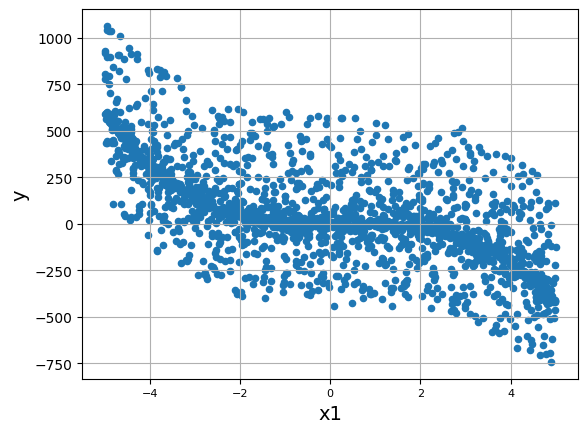

In [485]:
ejercicio2.plot(kind="scatter", x="x1", y="y", grid=True)
plt.show()

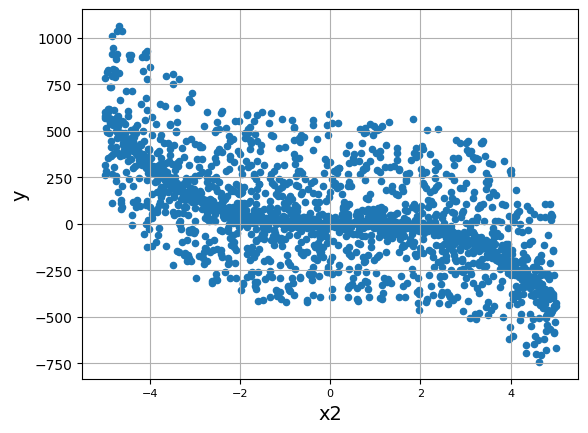

In [486]:
ejercicio2.plot(kind="scatter", x="x2", y="y", grid=True)
plt.show()

### Dividir los datos

In [487]:
X = ejercicio2.drop('y', axis=1)

y = ejercicio2['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Probar modelos

Grado: 1, error entrenamiento:114.1325332619959 , error test: 107.91580745583335
Grado: 2, error entrenamiento:110.02485362032749 , error test: 105.24921364049044
Grado: 3, error entrenamiento:10.09929424561161 , error test: 10.274441608581098
Grado: 4, error entrenamiento:10.11296638981248 , error test: 10.218508483760875
Grado: 5, error entrenamiento:10.170710562750736 , error test: 10.166921740876008


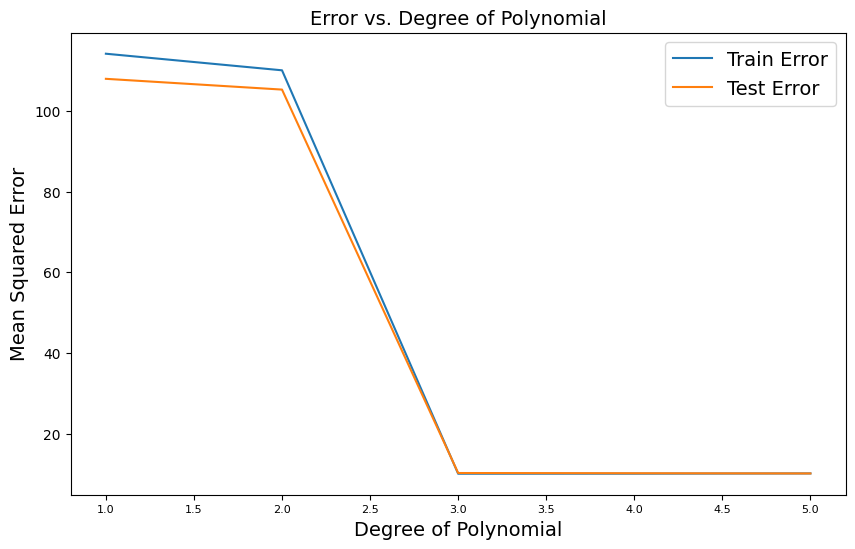

In [488]:
degrees = [1, 2, 3, 4, 5]
train_errors = []
test_errors = []

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree=degree, include_bias=False), LinearRegression())
    model.fit(X_test,y_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_error= np.sqrt(mean_squared_error(y_train, y_train_pred) )#medir el error en el conjunto de entrenamiento
    test_error= np.sqrt(mean_squared_error(y_test, y_test_pred)) #medir el error en el conjunto de test
    train_errors.append(train_error)
    test_errors.append(test_error)
    print("Grado: {}, error entrenamiento:{} , error test: {}".format(degree, train_error,test_error))

plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, label='Train Error')
plt.plot(degrees, test_errors, label='Test Error')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error')
plt.title('Error vs. Degree of Polynomial')
plt.legend()
plt.show()

El mejor degree es 3, es el que menos error me da. He utilizado el RMSE para comprarar los errores y elegir el menor.

## ElasticNet

Grado: 1, error entrenamiento:114.3382459484873 , error test: 107.92616650488189
Grado: 2, error entrenamiento:110.24812365468 , error test: 105.2598520619831
Grado: 3, error entrenamiento:10.107068932615412 , error test: 10.275679260961622
Grado: 4, error entrenamiento:10.11615173382865 , error test: 10.220977507412561
Grado: 5, error entrenamiento:10.171001258396773 , error test: 10.169847171734402


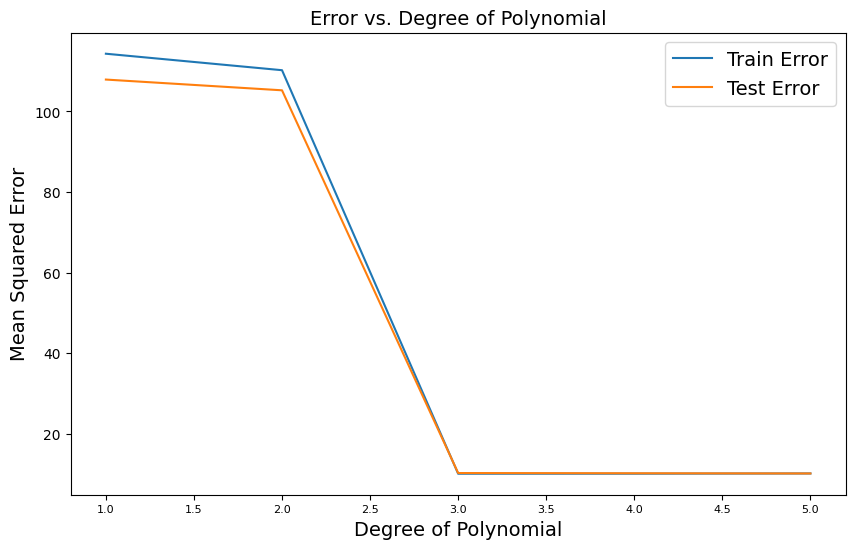

In [489]:
degrees = [1, 2, 3, 4, 5]
train_errors = []
test_errors = []

for degree in degrees:
    net_reg = ElasticNet(alpha=0.1, l1_ratio=0.5)
    model = make_pipeline(PolynomialFeatures(degree=degree, include_bias=False), net_reg)
    model.fit(X_test,y_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_error= np.sqrt(mean_squared_error(y_train, y_train_pred) )#medir el error en el conjunto de entrenamiento
    test_error= np.sqrt(mean_squared_error(y_test, y_test_pred)) #medir el error en el conjunto de test
    train_errors.append(train_error)
    test_errors.append(test_error)
    print("Grado: {}, error entrenamiento:{} , error test: {}".format(degree, train_error,test_error))

plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, label='Train Error')
plt.plot(degrees, test_errors, label='Test Error')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error')
plt.title('Error vs. Degree of Polynomial')
plt.legend()
plt.show()




Los mejores datos son {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.2}, en mi caso no ha mejorado

## EJERCICIO 3

Queremos predecir la calidad del vino (quality) a partir del resto de características.

Carga el conjunto de datos winequality.csv, explora los datos y divide el conjunto de datos en entrenamiento y pruebas (10% para las pruebas).

Crea una pipeline para preparar los datos y aplicar un algoritmo de máquinas de vector soporte, entrena el modelo (guarda el tiempo que tardas en entrenar el modelo) y evalúa el modelo en el conjunto de pruebas (no hace falta que pruebes con diferentes hiperparámetros...)

Crea una pipeline para preparar los datos y aplicar PCA que explique al menos el 95% de la varianza, aplica esta pipeline al conjunto de entrenamiento y al conjunto de pruebas.

Muestra cuantas dimensiones tenías al principio y cuantas después de aplicar PCA.

Aplica a los datos obtenido de aplicar PCA el algoritmo de máquinas de vector soporte, entrena el modelo (guarda el tiempo que tardas en entrenar el modelo) y evalúa el modelo en el conjunto de pruebas (no hace falta que pruebes con diferentes hiperparámetros...)

Compara el error y el tiempo empleado en los dos modelos (sin pca y con pca) e interpreta el resultado.


### Cargar los datos

In [490]:
def cargarCSV():
    try:
        return pd.read_csv("winequality.csv")
    except:
        print("Fichero no encontrado")

ejercicio3 = cargarCSV()

## Explorar los datos

In [491]:
ejercicio3.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,76.0,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,98.0,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,92.0,15.0,54.0,997.0000,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,75.0,17.0,60.0,998.0000,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,76.0,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [492]:
ejercicio3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [493]:
ejercicio3.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,84.830550,0.270976,2.538806,77.470294,15.874922,46.467792,58.321478,3.311113,0.658149,10.422983,5.636023
std,1.741096,234.417251,0.194801,1.409928,51.628973,10.460157,32.895324,232.081972,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.050000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.400000,0.090000,1.900000,65.000000,7.000000,22.000000,0.995640,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,77.000000,14.000000,38.000000,0.996800,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.660000,0.420000,2.600000,88.000000,21.000000,62.000000,0.998160,3.400000,0.730000,11.100000,6.000000
max,15.900000,1185.000000,1.000000,15.500000,611.000000,72.000000,289.000000,1001.000000,4.010000,2.000000,14.900000,8.000000


In [494]:
ejercicio3.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [495]:
X = ejercicio3.drop('quality', axis=1)

y = ejercicio3['quality']

In [496]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,76.0,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,98.0,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,92.0,15.0,54.0,997.0000,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,75.0,17.0,60.0,998.0000,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,76.0,11.0,34.0,0.9978,3.51,0.56,9.4


In [497]:
X.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

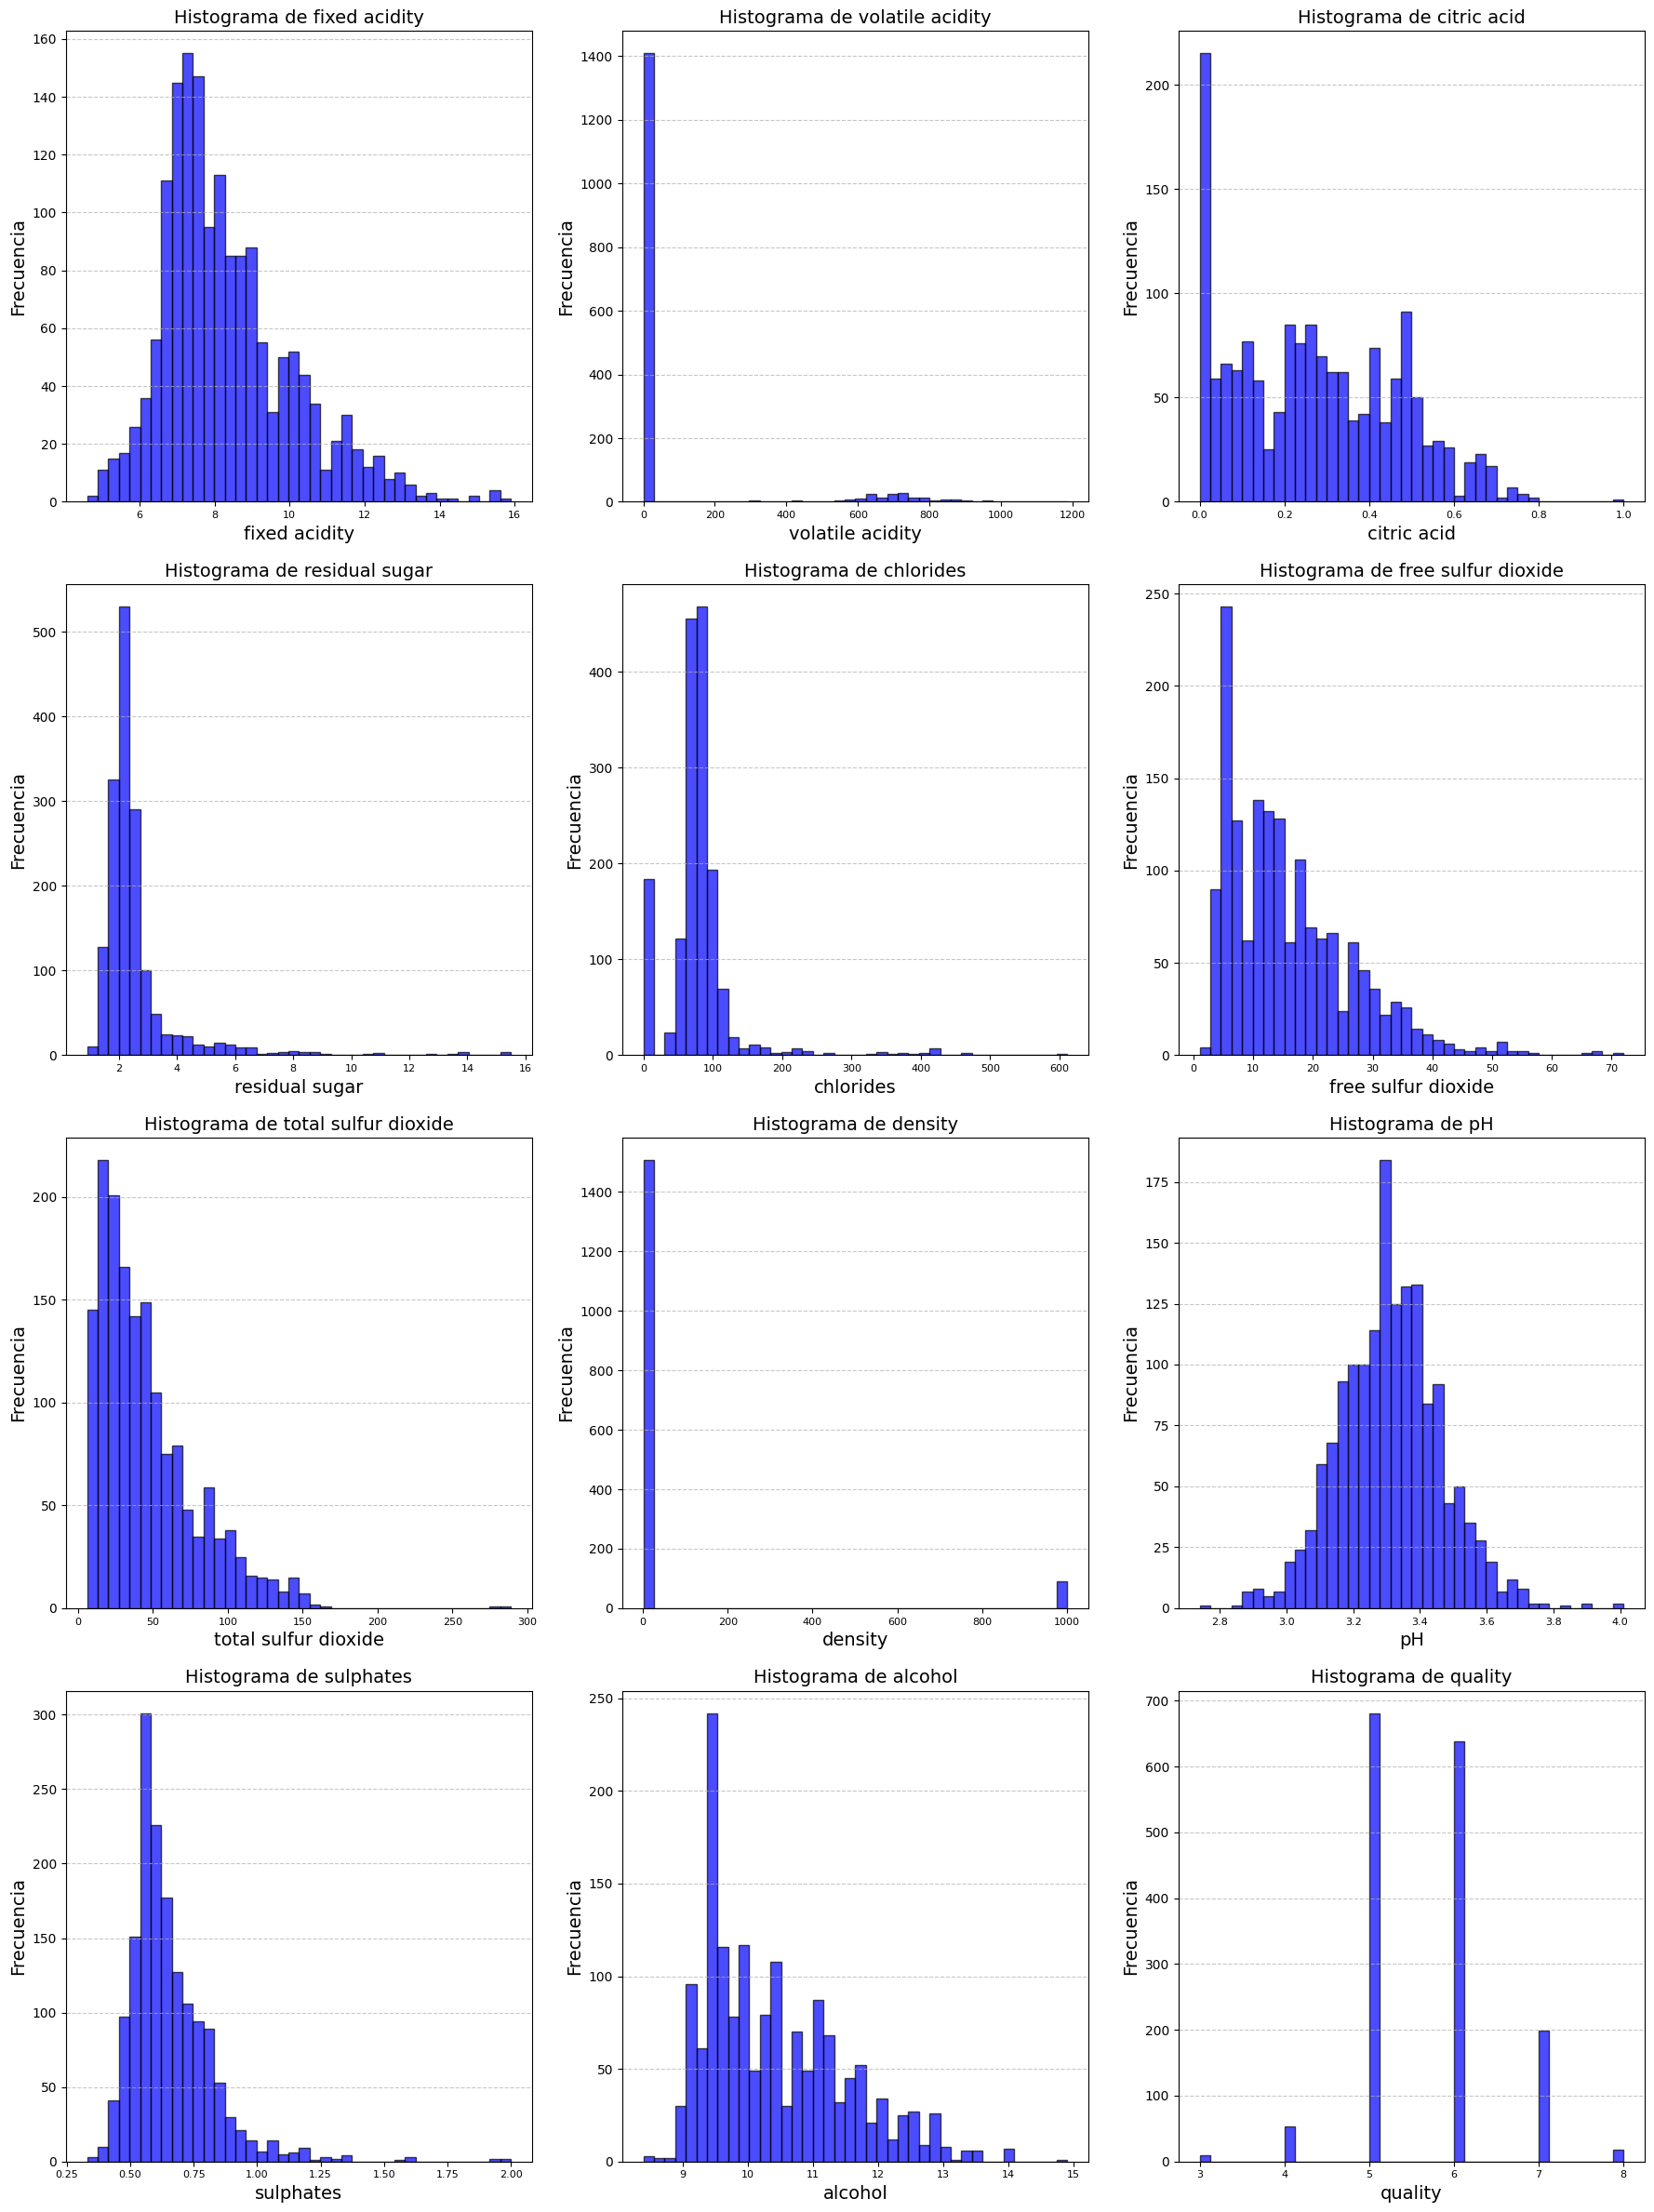

In [498]:
import math

# Separar las columnas numéricas y categóricas
numericas = ejercicio3.select_dtypes(include=['int64', 'float64']).columns

# Configuración de estilo de gráficos
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=10)

# Crear subplots para las variables numéricas
num_cols = len(numericas)
num_rows = math.ceil(num_cols / 3)
plt.figure(figsize=(18, 6 * num_rows))

for i, col in enumerate(numericas, 1):
    plt.subplot(num_rows, 3, i)
    plt.hist(ejercicio3[col].dropna(), bins=40, color='blue', alpha=0.7, edgecolor='black')
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


La mayoría de vinos son de entre calidad 5 y 6

In [499]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

### Pipeline

In [500]:
numericas_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'), 
    StandardScaler() 
)

svm = SVC(random_state=42)
pipeline_svm= make_pipeline(numericas_pipeline,svm)
# Cronometrar el tiempo de entrenamiento
start = time.time()
pipeline_svm.fit(X_train, y_train)
end = time.time()

print(f"Tiempo de entrenamiento SVM: {end - start:.2f} segundos")

Tiempo de entrenamiento SVM: 0.08 segundos


In [501]:
# Evaluar en el conjunto de prueba
y_pred_svm = pipeline_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Precisión de SVM: {accuracy_svm:.4f}")

Precisión de SVM: 0.6625


In [502]:
#Dimensionalidad previo a PCA
print(f"Dimensionalidad: {X_train.shape[1]} componentes principales")

Dimensionalidad: 11 componentes principales


In [503]:
pipeline_svm_pca = make_pipeline(numericas_pipeline,svm)
# Reducir dimensionalidad con PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Dimensionalidad reducida a: {X_train_pca.shape[1]} componentes principales")

Dimensionalidad reducida a: 2 componentes principales


In [504]:

# Entrenar SVM con PCA
print("Entrenando SVM con PCA...")
start = time.time()
pipeline_svm_pca.fit(X_train_pca, y_train)
end = time.time()

print(f"Tiempo de entrenamiento con PCA: {end - start:.2f} segundos")

Entrenando SVM con PCA...
Tiempo de entrenamiento con PCA: 0.07 segundos


In [505]:

# Evaluar en el conjunto de prueba
y_pred_svm_pca = pipeline_svm_pca.predict(X_test_pca)
accuracy_svm_pca = accuracy_score(y_test, y_pred_svm_pca)
print(f"Precisión de SVM con PCA: entrenamiento {accuracy_svm_pca:.4f}")



Precisión de SVM con PCA: entrenamiento 0.3937


In [506]:
# Evaluar en el conjunto de prueba
y_pred_svm_pca = pipeline_svm_pca.predict(X_train_pca)
accuracy_svm_pca = accuracy_score(y_train, y_pred_svm_pca)
print(f"Precisión de SVM con PCA: pruebas {accuracy_svm_pca:.4f}")

Precisión de SVM con PCA: pruebas 0.4371


Antes tenía 11 componentes principales, y ahora 2.
En mi caso estoy teniendo peor prescisión con PCA, lo que significa que se está pasando eliminando las redundancias. Además acierta más en pruebas que en el conjunto de entrenamiento. En este caso ( de estar hecho bien.. ) no es buena decisión usar reducir la dimensionalidad.

## EJERCICIO 4

Una empresa de coches ha sacado un nuevo modelo al mercado. Le ha preguntado a una red social quién ha comprado el producto, recaudando el sexo, la edad y el salario de cada uno de ellos. Ahora queremos construir un modelo que nos permita determinar con estos atributos si la persona comprará el producto o no, para tomar medidas en función de la respuesta para que lo acabe comprando.

Los datos están en el csv

### RECOPILACIÓN Y RECOLECCIÓN DE LOS DATOS

####  OBTENER LOS DATOS

In [507]:
def cargarCSV():
    try:
        return pd.read_csv("compras.csv")
    except:
        print("Fichero no encontrado")

compras = cargarCSV()

In [508]:
compras.head()

,Identificador,Sexo,Edad,Salario,Compra
0,15624510,Hombre,19,19000,0
1,15810944,Hombre,35,20000,0
2,15668575,Mujer,26,43000,0
3,15603246,Mujer,27,57000,0
4,15804002,Hombre,19,76000,0


In [509]:
compras.describe()

,Identificador,Edad,Salario,Compra
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


In [510]:
compras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Identificador  400 non-null    int64 
 1   Sexo           400 non-null    object
 2   Edad           400 non-null    int64 
 3   Salario        400 non-null    int64 
 4   Compra         400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


#### EXPLORAR LOS DATOS 
Con exhaustividad: datos estadísticos, gráficos, correlaciones... e indicar las deduciones a las que llegas

No creo que el identificador me diga nada en un gráfico, siendo como un ID

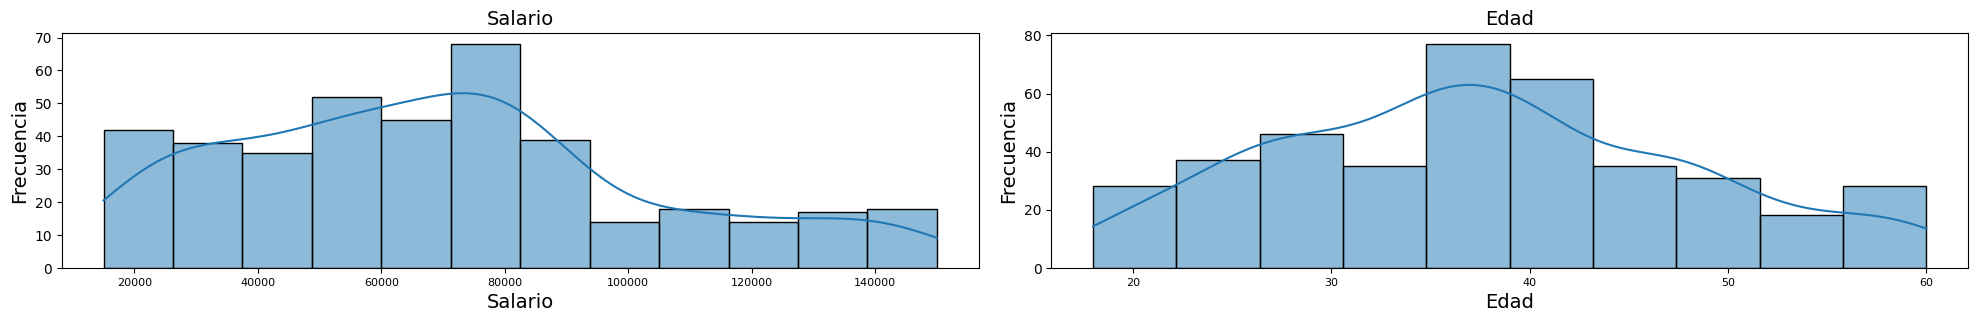

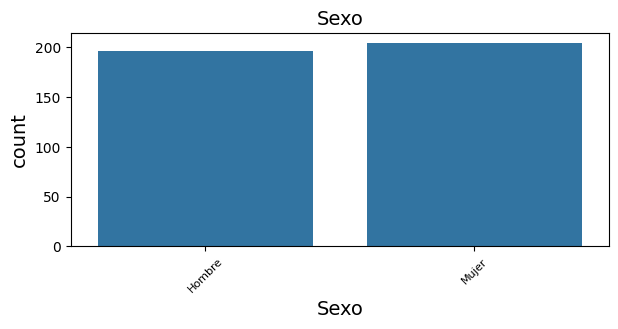

In [511]:
numericas = ['Salario','Edad']  
categoricas = ['Sexo']
# Gráfico de histograma 
plt.figure(figsize=(20, 12))
for i, var in enumerate(numericas):
    plt.subplot(4, 2, i+1)
    sns.histplot(compras[var], kde=True)
    plt.title(f'{var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Gráfico de barras para variables categóricas
plt.figure(figsize=(12, 12))
for i, var in enumerate(categoricas):
    plt.subplot(4, 2, i+1)
    sns.countplot(x=var, data=compras)
    plt.title(f'{var}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

 Está muy igualado en genero, hay más mujeres pero la diferencia es muy baja.
 Vemos que la distribución de salario, es mayor en los más bajos, llegando al punto máximo hacia la mitad. La gente con sueldo mayor es menor que la de sueldo más bajo. distribución de la edad es bastante "normal", me refiero a que el punto máximo está mas o menos a la mitad, y de ahi a cada lado va bajando. Es decir, la franja de edad que más ha comprado es la de entre 35-45 años.

In [512]:
# Agrupar por pclass y calcular media de supervivencia
media = compras.groupby('Sexo')['Compra'].mean().reset_index()

# Crear un nuevo DataFrame con el resultado
resultado_df = pd.DataFrame({
    'Sexo': media['Sexo'],
    'Compra': media['Compra']
})

# Ordenar de manera descendente
resultado_df = resultado_df.sort_values('Compra', ascending=False).reset_index(drop=True)

print(resultado_df)

     Sexo    Compra
0   Mujer  0.377451
1  Hombre  0.336735


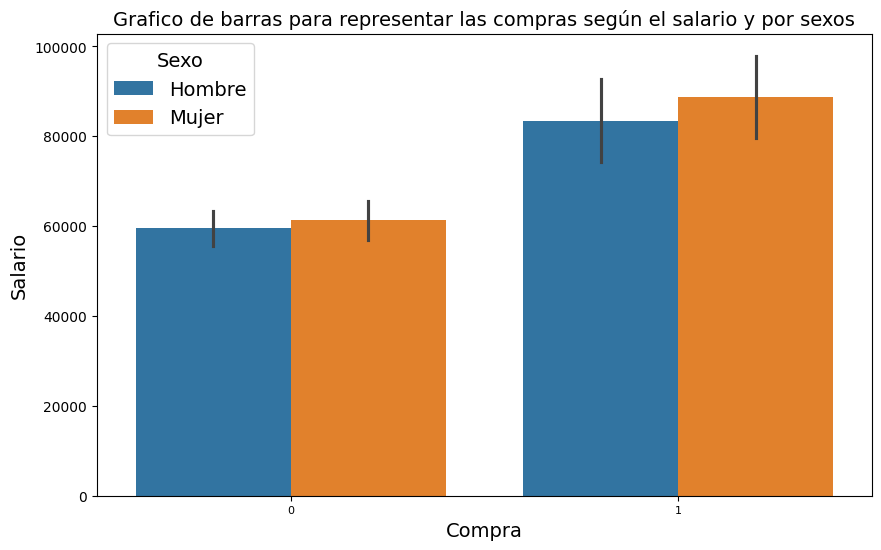

In [513]:

plt.figure(figsize=(10, 6))
sns.barplot(data=compras, x='Compra', y='Salario', hue='Sexo')

# Añadir títulos y etiquetas
plt.title('Grafico de barras para representar las compras según el salario y por sexos')
plt.xlabel('Compra')
plt.ylabel('Salario')
plt.legend(title='Sexo')

# Mostrar el gráfico
plt.show()


Podemos ver que las mujeres compran más que los hombres

In [514]:
# Solo con los numericos
correlaciones = compras.corr(numeric_only=True)

correlaciones["Compra"].sort_values(ascending=False)

Compra           1.000000
Edad             0.622454
Salario          0.362083
Identificador    0.007120
Name: Compra, dtype: float64

In [515]:
correlaciones.style.background_gradient()

,Identificador,Edad,Salario,Compra
Identificador,1.000000,-0.000721,0.071097,0.007120
Edad,-0.000721,1.000000,0.155238,0.622454
Salario,0.071097,0.155238,1.000000,0.362083
Compra,0.007120,0.622454,0.362083,1.000000


Podemos ver que la variable mas correlacionada con comprar o no, es la edad. El salario también está correlacionado pero no tanto como la edad. La variable identificador, como sospechabamos, no nos da ninguna información relevante.

In [516]:
target_corr = correlaciones['Compra'].abs()
target_corr
# columas com menos correlación que 0.04
eliminar = target_corr[target_corr<0.04].index.to_list()
# Eliminar columnas 
compras = compras.drop(columns=eliminar)

In [517]:
compras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Sexo     400 non-null    object
 1   Edad     400 non-null    int64 
 2   Salario  400 non-null    int64 
 3   Compra   400 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 12.6+ KB


#### DIVIDIR LOS DATOS EN CONJUNTO DE ENTRENAMIENTO Y PRUEBAS

No se especifica porcentaje de prueba, lo dejo en 20%

In [518]:
X = compras.drop('Compra', axis=1)

y = compras['Compra']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### PREPARAR LOS DATOS
Algunas pistas a tener en cuenta (** esto no quiere decir que sólo haya que hacer esto**):
* No usar las características que no sirven
* Tratar los valores nulos (aunque ahora no haya)
* Edad: primeramente convertir en categórica poniendo las siguientes etiquetas y luego aplicar el cambio que procede en las variables categóricas (es para aplicar los diferentes tipos de transformaciones que hay, no porque tenga mucho sentido).
  * 0-20 --> Rango1
  * 20-30 --> Rango 2
  * 30-40 --> Rango 3
  * 40-50 --> Rango 4
  * 50- --> Rango 5

* Salario: aplicar logaritmo (aunque no tenga una cola larga a la derecha) y luego estandarizar

In [519]:
def formatearSex(function_transformer, feature_names_in):
     return ['Sexo']
#male 0 female 1
def sexNumeros(X):
     return np.where(X == 'Hombre',1,0)

def age_name(function_transformer, feature_names_in):
     return ['Edad']
def separar_age(X):
     X=pd.DataFrame(X,columns=['Edad'])
     X['Edad'] = pd.cut(X['Edad'], bins=[0,20,30,40,50,np.inf], labels=["Rango1","Rango2","Rango3","Rango4","Rango5"]).to_numpy()
     return X

edad_pipeline=make_pipeline(
     SimpleImputer(strategy='mean'),
     FunctionTransformer(separar_age,feature_names_out=age_name)
)
sexo_pipeline=make_pipeline(
     SimpleImputer(strategy="most_frequent"), 
     FunctionTransformer(sexNumeros,feature_names_out=formatearSex)
)
salario_pipeline = make_pipeline(
     SimpleImputer(strategy="mean"),
     FunctionTransformer(np.log, feature_names_out="one-to-one"),
     StandardScaler()
)
pipeline_compras = ColumnTransformer([
     ('Salario', salario_pipeline, ['Salario']), 
     ('Sexo', sexo_pipeline, ['Sexo']),
     ('Edad', edad_pipeline, ['Edad']), 
 ],
 remainder='passthrough',verbose_feature_names_out=False
 )

transformado = pipeline_compras.fit_transform(compras)

# Obtener nombres de las características finales
feature_names = pipeline_compras.get_feature_names_out()

# Crear el DataFrame final
df_final = pd.DataFrame(transformado, columns=feature_names)

# Mostrar el resultado
print(df_final.head())


    Salario Sexo    Edad Compra
0 -2.095414    1  Rango1      0
1 -2.002996    1  Rango3      0
2 -0.623805    0  Rango2      0
3 -0.115976    0  Rango2      0
4  0.402359    1  Rango1      0
